In [52]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.robust import mad

In [53]:
# Load Data
df = pd.read_csv("Datasets/DailyDelhiClimateTrain.csv")
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

ts = df.columns

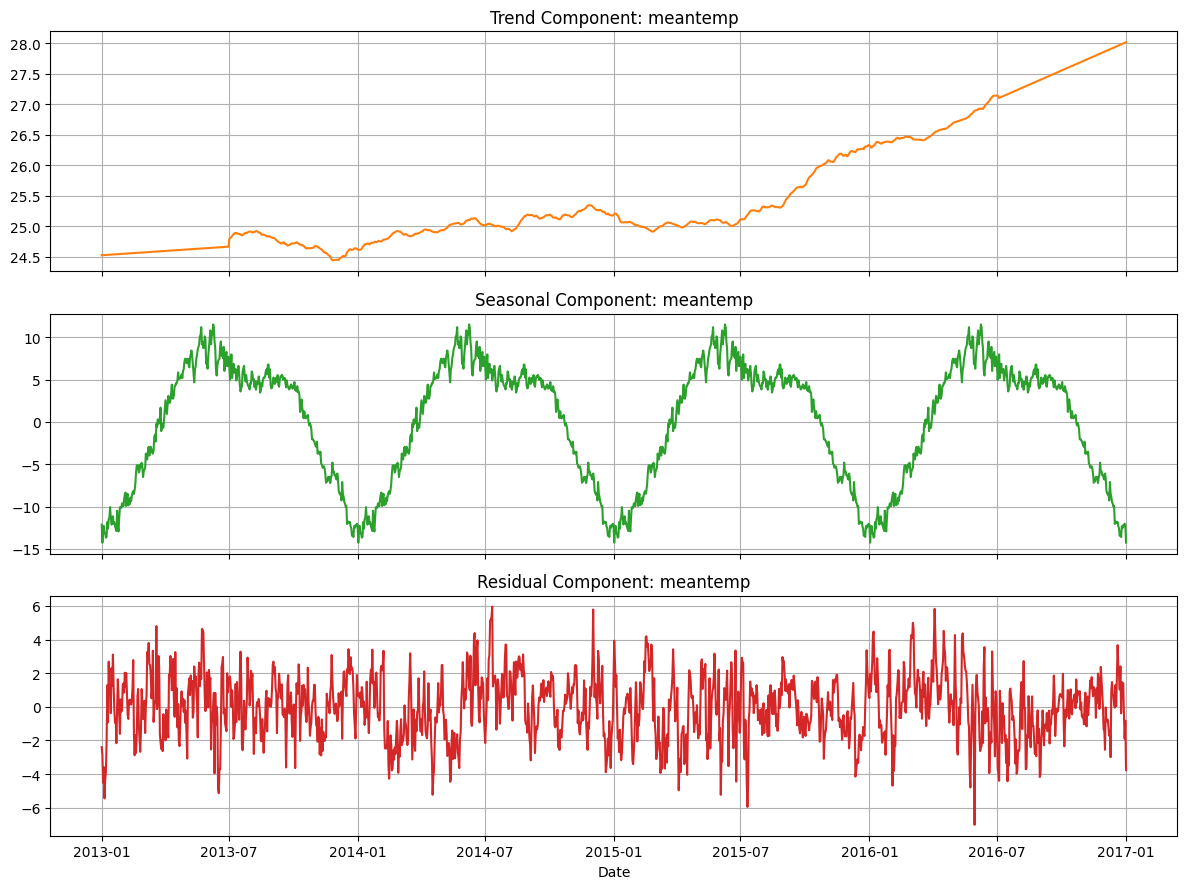

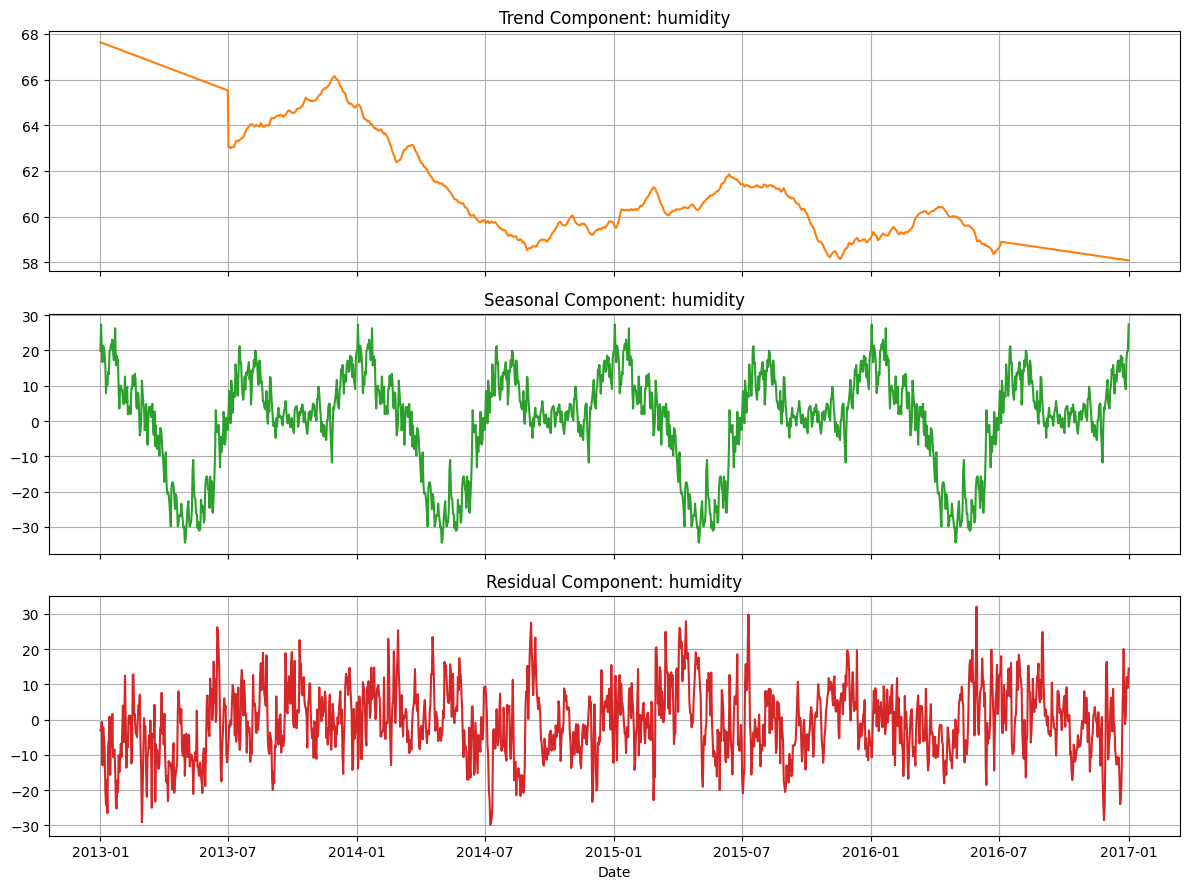

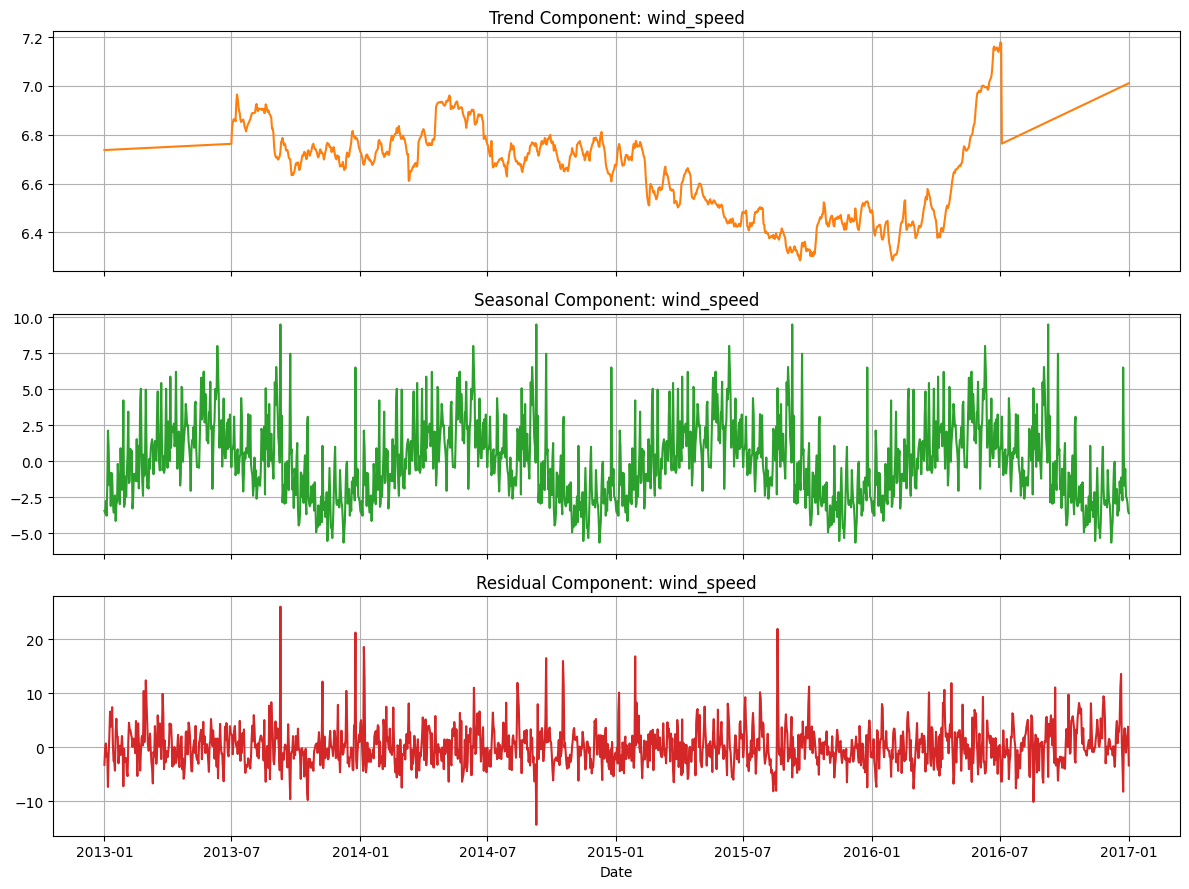

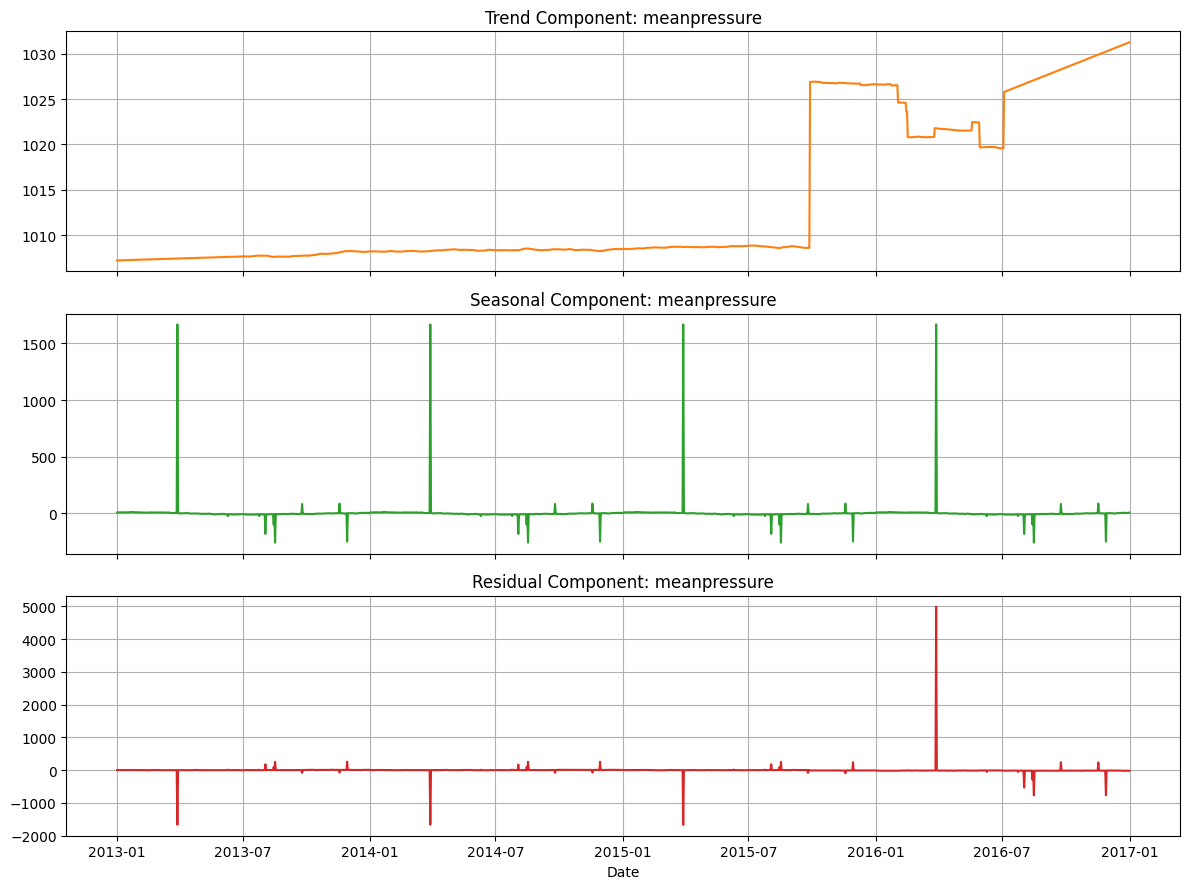

In [56]:
for col in ts:
    # Seasonal Decomposition
    result = seasonal_decompose(df[col], model='additive', period=365, extrapolate_trend='freq')
    
    # Plot
    fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)
    axes[0].plot(result.trend, color='tab:orange')
    axes[0].set_title(f'Trend Component: {col}')
    axes[0].grid(True)
    axes[1].plot(result.seasonal, color='tab:green')
    axes[1].set_title(f'Seasonal Component: {col}')
    axes[1].grid(True)
    axes[2].plot(result.resid, color='tab:red')
    axes[2].set_title(f'Residual Component: {col}')
    axes[2].grid(True)
    plt.xlabel('Date')
    plt.tight_layout()
    plt.show()

### Outlier Analysis and Handling

A seasonal decomposition (STL) was performed on all columns of the dataset to investigate potential outliers. The **range of the residuals** for each feature indicates whether there are extreme values in the data:  

- For **`meantemp`**, **`humidity`**, and **`wind_speed`**, the residuals range between approximately -30 and 30. This shows that there are no extreme outliers that require special handling.  
- For **`meanpressure`**, there is a very large spike, with a value of **7679.33** on **2016-03-28**, which clearly represents an outlier.  

#### Outlier Handling

To address outliers, an **STL decomposition** was applied:  
1. Outliers are identified based on the residuals.  
2. The outlier values are then set to `NaN`.  
3. Missing values (`NaN`) are replaced using **interpolation**, producing a cleaned time series while preserving the overall trend and seasonal pattern.


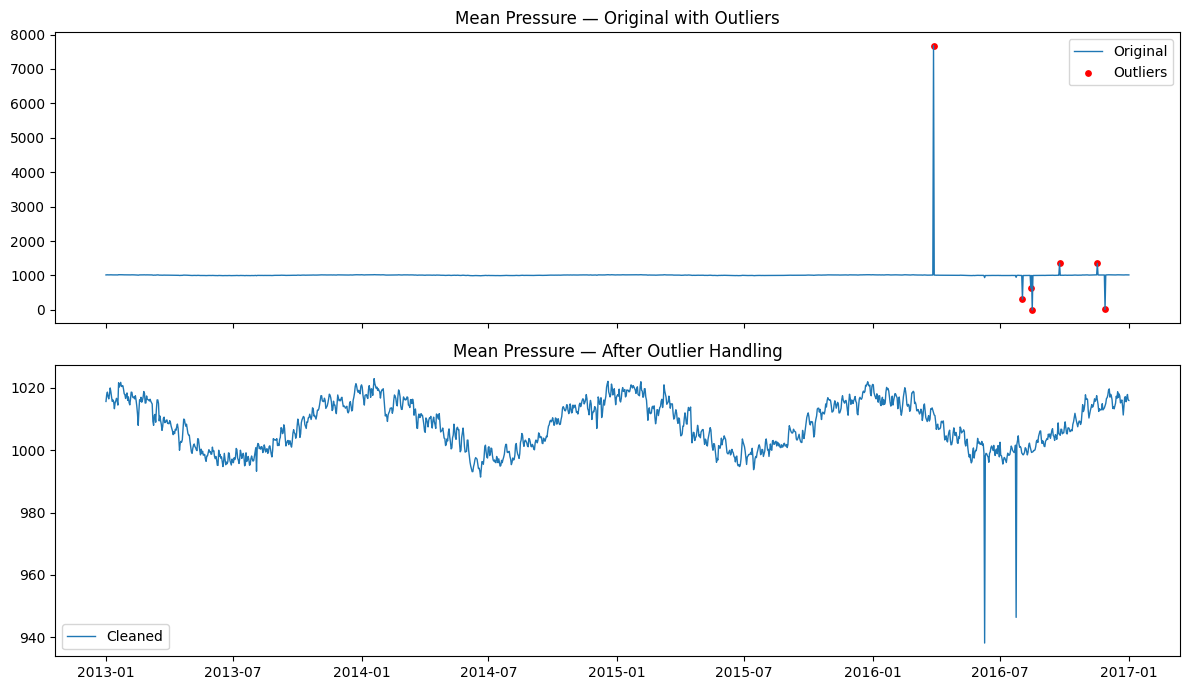

2016-03-28 : 7679.333333333333 -> 1012.0625
2016-08-02 : 310.4375 -> 998.8125
2016-08-14 : 633.9 -> 1000.1785714285716
2016-08-16 : -3.0416666666666665 -> 999.4021164021165
2016-09-24 : 1352.6153846153843 -> 1005.0520186335402
2016-11-17 : 1350.2962962962963 -> 1016.1153846153845
2016-11-28 : 12.045454545454543 -> 1014.2954545454546


In [55]:
series = df['meanpressure']
stl = STL(series, period=365)
res = stl.fit()

residuals = res.resid

resid_mad = mad(residuals)
outlier_mask = abs(residuals) > 3 * resid_mad
outlier_mask &= (series < 700) | (series > 1320)

clean_series = series.copy()
clean_series[outlier_mask] = float('nan')
clean_series = clean_series.interpolate()

fig, ax = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

ax[0].plot(series, label='Original', linewidth=1)
ax[0].scatter(series.index[outlier_mask], series[outlier_mask], 
              color='red', s=15, label='Outliers')
ax[0].set_title("Mean Pressure — Original with Outliers")
ax[0].legend()

ax[1].plot(clean_series, label='Cleaned', linewidth=1)
ax[1].set_title("Mean Pressure — After Outlier Handling")
ax[1].legend()

plt.tight_layout()
plt.show()

outlier_indices = series.index[outlier_mask]

for idx in outlier_indices:
    print(f"{idx.date()} : {series[idx]} -> {clean_series[idx]}")
    